<a href="https://colab.research.google.com/github/DhafinRA/ML-Upatik/blob/main/Food_Classification_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT DEPENDENCIES

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten,GlobalAveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import ResNet50V2
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

In [38]:
#HYPERPARAMETER

EPOCHS = 20
LOSS = CategoricalCrossentropy()
OPTIMIZERS = Adam()
input_shape = (150,150,3)
train_dir = "Image Eye\Train"
test_dir = "Image Eye\Test"

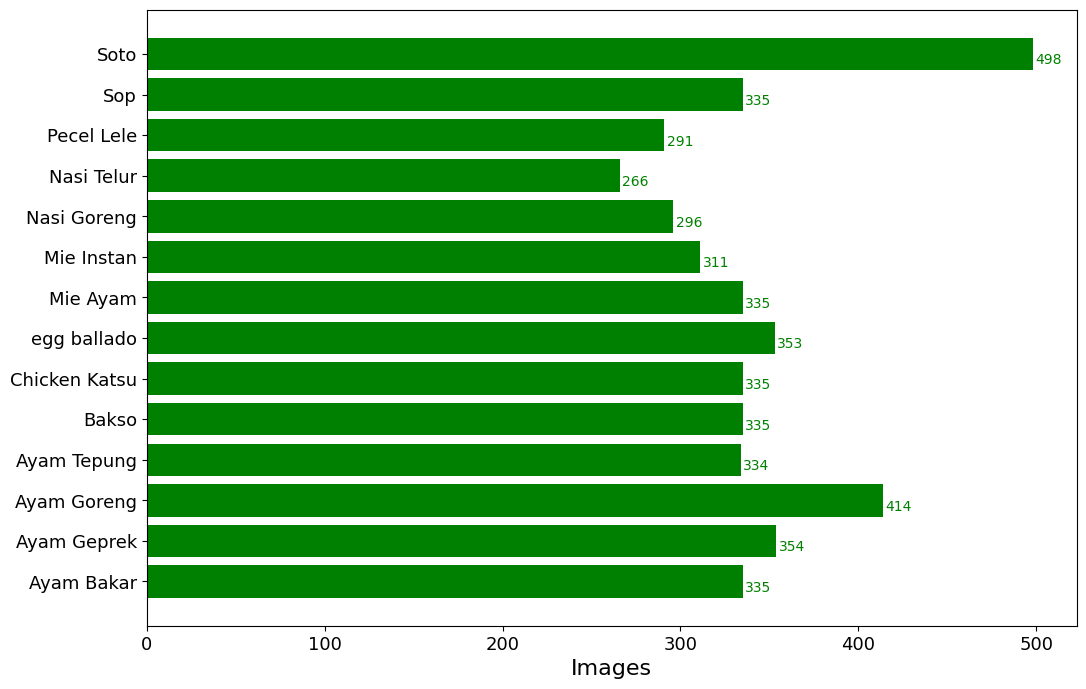

In [3]:
data=dict()

for i in os.listdir(train_dir):
    sub_dir=os.path.join(train_dir,i)
    count=len(os.listdir(sub_dir))
    data[i]=count
    
  
keys = data.keys()
values = data.values()

colors=["red" if x<= 150 else "green" for x in values]

fig, ax = plt.subplots(figsize=(12,8))
y_pos=np.arange(len(values))
plt.barh(y_pos,values,align='center',color=colors)
for i, v in enumerate(values):
    ax.text(v+1.4, i-0.25, str(v), color=colors[i])
ax.set_yticks(y_pos)
ax.set_yticklabels(keys)
ax.set_xlabel('Images',fontsize=16)
plt.xticks(color='black',fontsize=13)
plt.yticks(fontsize=13)
plt.show()

Labeling Photo Using ImageDataGenerator

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    height_shift_range=0.2,
                                    width_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

Show All Classes

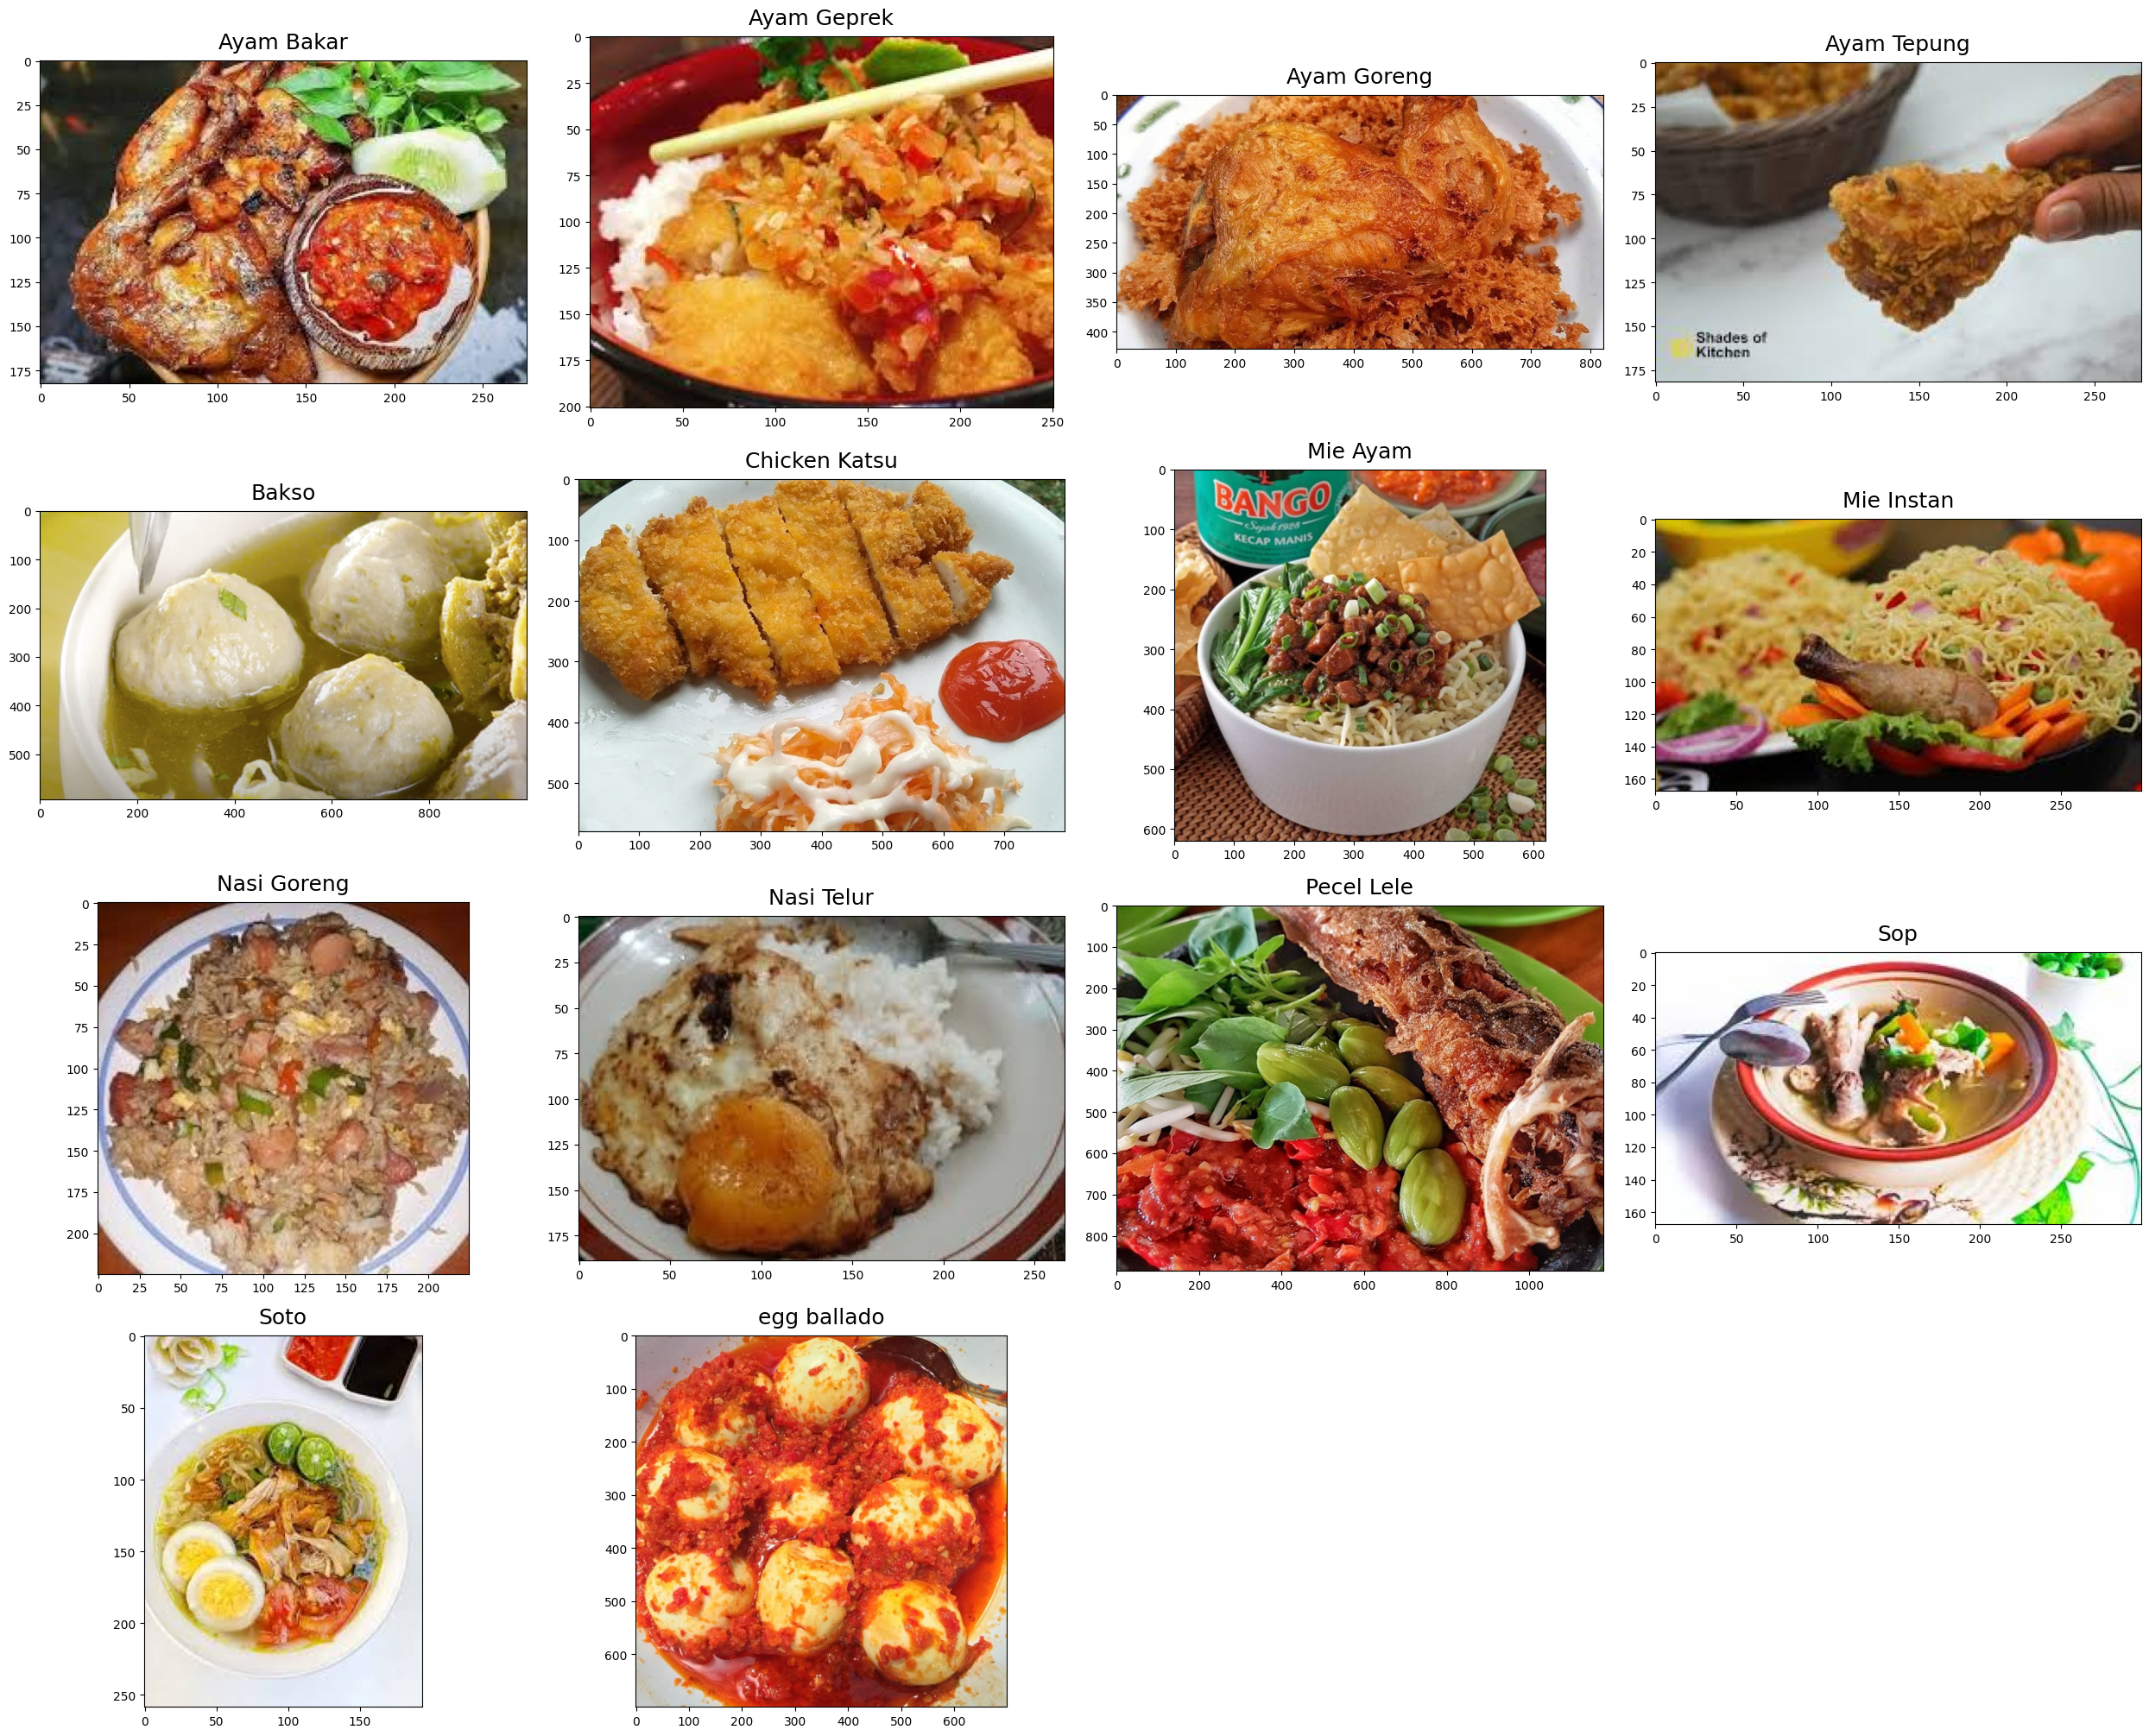

In [5]:
images = []
labels = []

for food_folder in sorted(os.listdir(train_dir)):
    food_items = os.listdir(train_dir + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_dir,food_folder,food_selected))

fig=plt.figure(1, figsize=(25, 25))

for subplot,image_ in enumerate(images):
    category=image_.split('\\')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(5, 4, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    labels.append(category)

plt.tight_layout()

In [6]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=10,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(150, 150),
                                                    batch_size=2,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

Found 4783 images belonging to 14 classes.
Found 976 images belonging to 14 classes.


Making Callbacks for Training

In [7]:
# class myCallback(tf.keras.callbacks.Callback):
#         def on_epoch_end(self, epoch, logs={}):
#             if (logs.get('val_accuracy') > 0.83 and logs.get('accuracy')>0.83):
#                 print('\naccuracy and validation accuracy reached 83%,so cancelling training!')
#                 self.model.stop_training = True
                
# callbacks = myCallback()

model_checkpoint_callback = ModelCheckpoint(
    filepath='Model/model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    restore_best_weights = True,
)

In [33]:
resnet = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

total_layers = len(resnet.layers)

fn_layers = total_layers - round(int(0.6 * total_layers))
# Freezing the Base Layer
for layer in resnet.layers[:fn_layers]:
    layer.trainable = False

Making Model

In [34]:
model = Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dense(512,activation='relu'),
    Dense(64,activation='relu'),
    Dense(14,activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 dense_5 (Dense)             (None, 14)                910       
                                                                 
Total params: 24,647,630
Trainable params: 23,435,726
Non-trainable params: 1,211,904
__________________________________

In [35]:
# model.load_weights('Weights/weight')
model.compile(loss='CategoricalCrossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train_generator,epochs=EPOCHS,validation_data=test_generator,callbacks=[model_checkpoint_callback])

Epoch 1/20
479/479 [==============================] - 79s 156ms/step - loss: 2.3258 - accuracy: 0.2122 - val_loss: 2.8976 - val_accuracy: 0.1988
Epoch 2/20
479/479 [==============================] - 73s 153ms/step - loss: 1.8699 - accuracy: 0.3533 - val_loss: 3.2468 - val_accuracy: 0.2992
Epoch 3/20
479/479 [==============================] - 46s 95ms/step - loss: 1.6306 - accuracy: 0.4487 - val_loss: 1.7882 - val_accuracy: 0.4252
Epoch 4/20
479/479 [==============================] - 37s 77ms/step - loss: 1.4424 - accuracy: 0.5183 - val_loss: 1.6443 - val_accuracy: 0.4990
Epoch 5/20
479/479 [==============================] - 36s 75ms/step - loss: 1.3025 - accuracy: 0.5637 - val_loss: 1.3941 - val_accuracy: 0.5656
Epoch 6/20
479/479 [==============================] - 35s 74ms/step - loss: 1.1901 - accuracy: 0.6063 - val_loss: 1.0412 - val_accuracy: 0.6547
Epoch 7/20
479/479 [==============================] - 34s 71ms/step - loss: 1.1178 - accuracy: 0.6189 - val_loss: 1.4021 - val_accurac

In [11]:
model.save_weights('Weights/weight')

RESULTS

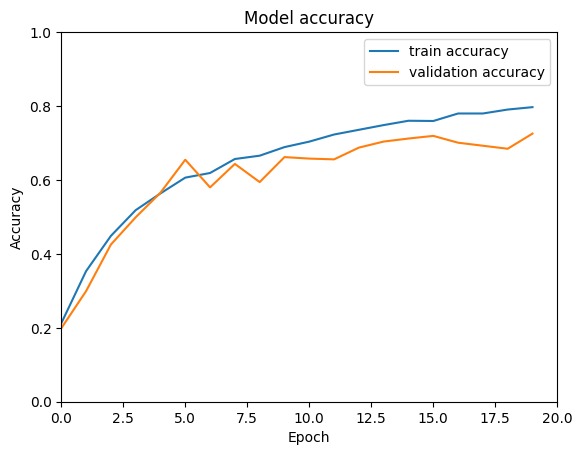

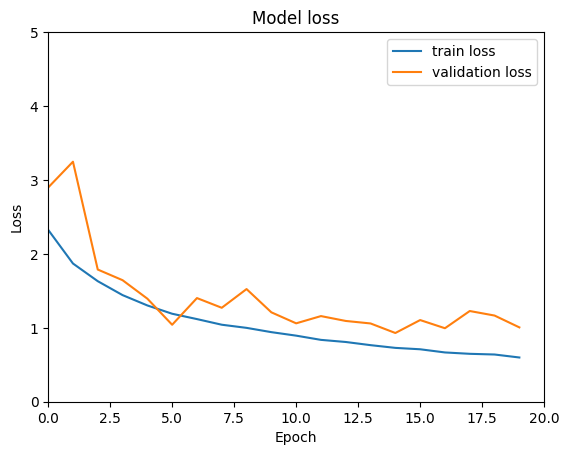

In [39]:
def plot_accuracy(history,x_axis=EPOCHS):
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xlim(0,EPOCHS)
    plt.ylim(0,1)
    plt.legend(loc='best')
    plt.show()

def plot_loss(history,x_axis=EPOCHS):
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xlim(0,EPOCHS)
    plt.ylim(0,5)
    plt.legend(loc='best')
    plt.show()

plot_accuracy(history)
plot_loss(history)

In [18]:
predictions = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(test_generator.labels, predictions)
clr = classification_report(test_generator.labels, predictions, target_names=test_generator.class_indices, zero_division=0)

488/488 [==============================] - 6s 11ms/step


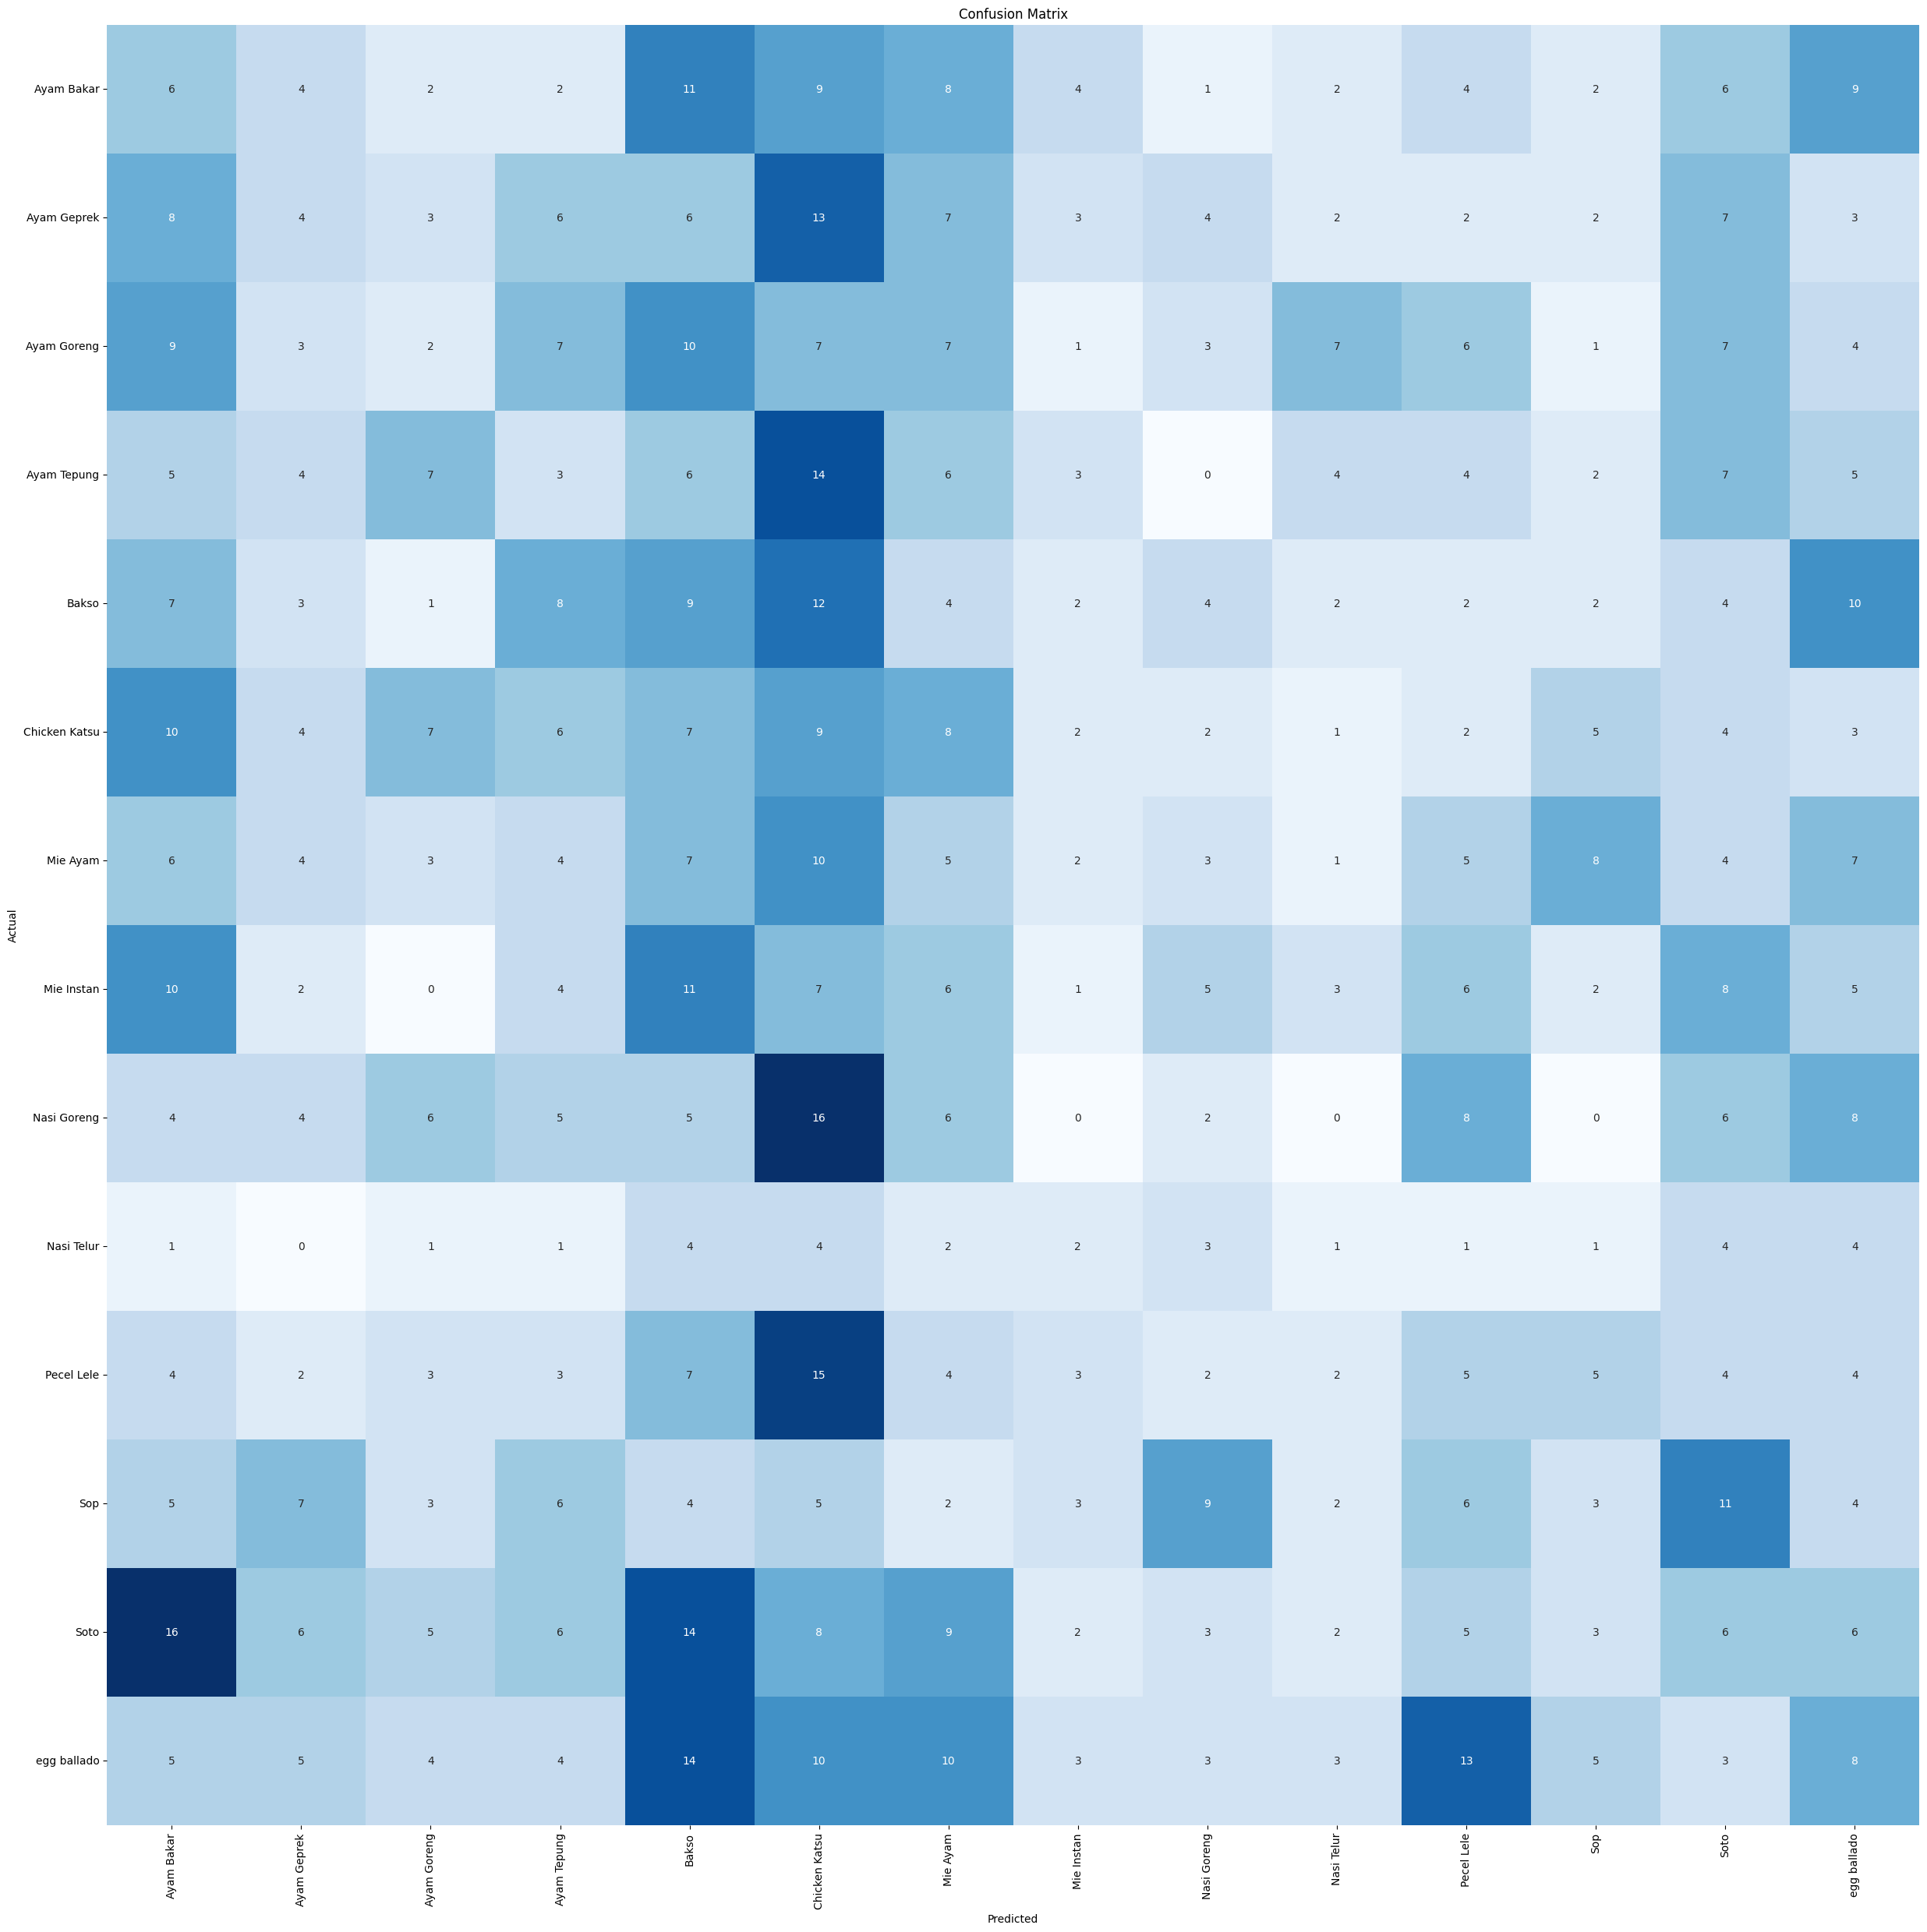

In [19]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(14) + 0.5, labels=test_generator.class_indices, rotation=90)
plt.yticks(ticks=np.arange(14) + 0.5, labels=test_generator.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

   Ayam Bakar       0.06      0.09      0.07        70
  Ayam Geprek       0.08      0.06      0.07        70
  Ayam Goreng       0.04      0.03      0.03        74
  Ayam Tepung       0.05      0.04      0.04        70
        Bakso       0.08      0.13      0.10        70
Chicken Katsu       0.06      0.13      0.09        70
     Mie Ayam       0.06      0.07      0.07        69
   Mie Instan       0.03      0.01      0.02        70
  Nasi Goreng       0.05      0.03      0.04        70
   Nasi Telur       0.03      0.03      0.03        29
   Pecel Lele       0.07      0.08      0.08        63
          Sop       0.07      0.04      0.05        70
         Soto       0.07      0.07      0.07        91
  egg ballado       0.10      0.09      0.09        90

     accuracy                           0.07       976
    macro avg       0.06      0.06      0.06       976
 weighted avg   